In [3]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot
import matplotlib.pyplot as plt
#!pip install pmdarima
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean
import os
from sklearn.metrics import mean_squared_error

In [5]:
def make_censored_oh(Y, C, K):
    """
    Helper function that zeros out Y (after it has been digitized) based on whether or not
    the patient has been censored at that particular time point. 
    """
    Yr,Cr = Y.ravel(), C.ravel()
    oh    = np.zeros((Y.shape[0], K))
    for k in range(Y.shape[0]):
        oh[k, Yr[k]]= 1.
    return oh
    
def digitize_outcomes(Y, Yvalid, Ytest, Ymax, K, method='quantiles'):
    """
    Helper function that digitizes outcomes, which means it converts a single real number
    corresponding to date of death (for example) into a sequential vector that bins intermediate
    values.
    """
    if method=='quantiles':
        K_m_2     = K-1 # correct for bin edges
        probs     = np.arange(K_m_2+1)/float(K_m_2)
        bin_edges = stats.mstats.mquantiles(Y, probs)#[0, 2./6, 4./6, 1])
        bin_edges = bin_edges.tolist()
        bin_edges+= [Ymax]
        bin_edges = bin_edges
    elif method=='uniform':
        bin_edges = np.linspace(0, Ymax, K+1)
        bin_edges = bin_edges.tolist()
    else:
        raise ValueError('bad setting for method')
    predict = []
    for k in range(len(bin_edges)-1):
        predict.append((bin_edges[k]+bin_edges[k+1])/2.)
    predict = np.array(predict)
    
    Ytr  = np.digitize(Y.astype(float).ravel(), bin_edges)-1
    Yva  = np.digitize(Yvalid.astype(float).ravel(), bin_edges)-1
    Yte  = np.digitize(Ytest.astype(float).ravel(), bin_edges)-1
    print (Ytr.max()+1, Yva.max()+1, Yte.max()+1)
    assert predict.shape[0]==K,'Expecting K categories'
    return Ytr, Yva, Yte, predict

def load_mmrf_quick(fold_span = range(5), fval=None):
    """
    Helper function to load in data tensors from pkl files.
    
    Args: 
        fold_span: list of folds that we wish to select 
        fval: path to cleaned output files
    Returns: 
        dset_rest: returns data dictionary with folds and corresponding train, test, and validation
        sets.
    """
#     dir_path = os.path.dirname(os.path.realpath(__file__))
#     fval     = os.path.join(dir_path, 'output/cleaned_mm_fold'+suffix+'.pkl')
    print( 'loading from:', fval)
    dset_rest = {}
    for foldnum in fold_span:
        fn = fval.replace('_fold',str(foldnum))
        with open(fn, 'rb') as f:
            dset = pickle.load(f)
        dset_rest[foldnum] = dset[foldnum]
    return dset_rest

def load_mmrf(fold_span = range(5), data_dir=None, digitize_K = 0, digitize_method = 'uniform', \
              subsample = False, add_syn_marker=False, restrict_markers=[], \
              window='all', data_aug=False, ablation=False, feats=[]):
    """
    Main function that loads the tensors from the stored .pkl files (which are generated by 
    running python build_mmrf_dataset.py) and returns the dataset. 
    
    Args: 
        fold_span: list of folds that we wish to select 
        suffix: string that might appear in .pkl file names (e.g. _2mos), used to define path to 
        pickle files 
        digitize_K: int that determines to what extent to "digitize" outcomes into bins 
        digitize_method: method to digitize (either 'uniform' or 'quantiles')
        subsample: bool for whether or not to subsample training set 
        add_syn_marker: bool for whether or not to include a synthetic marker that is constructed 
        from observed lab values 
        restric_markers: bool for whether or not to restrict markers to serum M protein and the 
        synthetic marker
        window: string that determines how masks are going to be constructed (e.g. only look 
        at first and second line therapies for each patient). can be "all", "first_second", 
        or "second".      
    Returns: 
        new_dset: returns data dictionary with folds and corresponding train, test, and validation
        sets.
    """
    new_dset = load_mmrf_quick(fold_span = fold_span, fval=data_dir)
    
    # Make sure we only see data up to maxT
    for fold in fold_span:
        for tvt in ['train', 'valid', 'test']:
            M      = new_dset[fold][tvt]['m']
            m_t    = ((np.flip(np.cumsum(np.flip(M.sum(-1), (1,)), 1), (1,))>1.)*1)
            maxT   = m_t.sum(-1).max()
            new_dset[fold][tvt]['x'] = new_dset[fold][tvt]['x'][:,:maxT,:]
            new_dset[fold][tvt]['a'] = new_dset[fold][tvt]['a'][:,:maxT,:]
            new_dset[fold][tvt]['m'] = new_dset[fold][tvt]['m'][:,:maxT,:]
            new_dset[fold][tvt]['m_a'] = new_dset[fold][tvt]['m_a'][:,:maxT,:]
    
    if subsample: 
        # Transfer data from train to test set
        dir_path = os.path.dirname(os.path.realpath(__file__))
        fval     = os.path.join(dir_path, 'samples.pkl')
        if os.path.exists(fval):
            with open(fval,'rb') as f:
                sample_idx = pickle.load(f)
        else:
            np.random.seed(0)
            sample_idx = {}
            for fold in fold_span:
                N   = new_dset[fold]['train']['x'].shape[0]
                Ns  = int(N*0.15)
                idxshuf = np.random.permutation(N)
                sample_idx[fold] = (idxshuf[:Ns], idxshuf[Ns:])
            with open(fval,'wb') as f:
                pickle.dump(sample_idx, f)
        for fold in fold_span:
            keep, move = sample_idx[fold]
            for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
                new_dset[fold]['test'][kk] = np.concatenate([new_dset[fold]['test'][kk], new_dset[fold]['train'][kk][move]], axis=0)
                new_dset[fold]['train'][kk]= new_dset[fold]['train'][kk][keep]
                
    if digitize_K>0:
        for fold in fold_span:
            Ytrain, Yvalid, Ytest = new_dset[fold]['train']['ys_seq'][:,0].ravel(), new_dset[fold]['valid']['ys_seq'][:,0].ravel(), new_dset[fold]['test']['ys_seq'][:,0].ravel()
            Ymax  = np.max([Ytrain.max(), Yvalid.max(), Ytest.max()])+0.1
            print ('Digitizing outcomes ymax:',Ymax)
            ytrain_bin, yvalid_bin, ytest_bin, predictions = digitize_outcomes(Ytrain, Yvalid, Ytest, Ymax, digitize_K, method=digitize_method)
            new_dset[fold]['train']['digitized_y'] = make_censored_oh(ytrain_bin, new_dset[fold]['train']['ce'].ravel(), digitize_K)
            new_dset[fold]['valid']['digitized_y'] = make_censored_oh(yvalid_bin, new_dset[fold]['valid']['ce'].ravel(), digitize_K)
            new_dset[fold]['test']['digitized_y']  = make_censored_oh(ytest_bin,  new_dset[fold]['test']['ce'].ravel(), digitize_K)
            new_dset[fold]['train']['prediction'] = predictions
            new_dset[fold]['valid']['prediction'] = predictions
            new_dset[fold]['test']['prediction']  = predictions
    for fold in fold_span:
        for k in ['train','valid','test']:
            m    = (new_dset[fold][k]['m_a'].sum(-1)>0.)*1.
            mask = (m[:,::-1].cumsum(1)[:,::-1]>0)*1.
            lot  = new_dset[fold][k]['a'][...,-1]
            lot[:,0]    = 1.
            lot[lot==0] = np.nan
            df = pd.DataFrame(lot)
            df.fillna(method='ffill', axis=1, inplace=True) # forward fill
            lot = df.values
            lot = lot*mask
            lot[lot>=3] = 3.
            lot_oh      = np.zeros(lot.shape+(4,))
            for i in range(lot.shape[0]):
                for j in range(lot.shape[1]):
                    lot_oh[i,j,lot[i,j].astype(int)] = 1
            lot_oh      = lot_oh[...,1:]
            time_val    = np.ones_like(lot_oh[:,:,[-1]])
            time_val    = np.cumsum(time_val, 1)*0.1
            time_val    = (lot_oh.cumsum(1)*lot_oh*0.1).sum(-1,keepdims=True)
            new_dset[fold][k]['a'] = np.concatenate([time_val, new_dset[fold][k]['a'][...,:-1], lot_oh], -1)
            new_dset[fold][k]['feature_names_a'] = np.array(['local_clock']+new_dset[fold][k]['feature_names_a'].tolist()[:-1]+['line1','line2','line3plus'])
            
            if add_syn_marker: # synthetic marker is sum of two major Igs based on myeloma type
                x    = new_dset[fold][k]['x']
                m    = new_dset[fold][k]['m']
                b    = new_dset[fold][k]['b']
                b_names = new_dset[fold][k]['feature_names'].tolist()
                x_names = new_dset[fold][k]['feature_names_x'].tolist()
                new_x   = np.zeros((x.shape[0],x.shape[1],x.shape[2]+1))
                new_m   = np.ones((m.shape[0],m.shape[1],m.shape[2]+1))
                for i in range(x.shape[0]): 
                    tseq = np.zeros((x.shape[1],)) 
                    mhseq = np.ones((x.shape[1],)); mlseq = np.ones((x.shape[1],))
                    if b[i,b_names.index('igg_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_igg')]
                        mhseq = m[i,:,x_names.index('serum_igg')]
                    elif b[i,b_names.index('iga_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_iga')]
                        mhseq = m[i,:,x_names.index('serum_iga')]
                    elif b[i,b_names.index('igm_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_igm')]
                        mhseq = m[i,:,x_names.index('serum_igm')]
                    
                    if b[i,b_names.index('kappa_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_kappa')]
                        mlseq = m[i,:,x_names.index('serum_kappa')]
                    elif b[i,b_names.index('lambda_type')] == 1.: 
                        tseq += x[i,:,x_names.index('serum_lambda')] 
                        mlseq = m[i,:,x_names.index('serum_lambda')]
        
                    tseq = tseq[:,np.newaxis]
                    new_x[i] = np.concatenate((new_dset[fold][k]['x'][i,:,:], tseq), axis=-1)
                    mseq     = np.ones((x.shape[1],1)) # change this line to make sure missingness pattern is correct (only 0 if both are missing)
#                     mseq = (mhseq.astype(int) | mlseq.astype(int)).astype(float)[:,np.newaxis]
                    new_m[i] = np.concatenate((new_dset[fold][k]['m'][i,:,:], mseq), axis=-1)
                new_dset[fold][k]['x'] = new_x; new_dset[fold][k]['m'] = new_m
                new_dset[fold][k]['feature_names_x'] = np.array(x_names + ['syn_marker'])
                print(f'adding synthetic marker in fold {fold}, set {k}...')
                print(f"new shape of X: {new_dset[fold][k]['x'].shape}")
                print(f"new shape of M: {new_dset[fold][k]['m'].shape}")
    
    if len(restrict_markers) != 0: 
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                x_names = new_dset[fold][k]['feature_names_x'].tolist()
                fs = []; ms = []
                for name in restrict_markers: 
                    f = new_dset[fold][k]['x'][...,x_names.index(name)][:,:,np.newaxis]
                    m = new_dset[fold][k]['m'][...,x_names.index(name)][:,:,np.newaxis]
                    fs.append(f); ms.append(m)
                new_dset[fold][k]['x'] = np.concatenate(tuple(fs),axis=-1)
                new_dset[fold][k]['m'] = np.concatenate(tuple(ms),axis=-1)
                new_dset[fold][k]['feature_names_x'] = np.array(restrict_markers)
                print(f'restricting longitudinal markers in fold {fold}, set {k}...')
                print(f"new shape of X: {new_dset[fold][k]['x'].shape}")
                print(f"new shape of M: {new_dset[fold][k]['m'].shape}")
    
    if window == 'first_second':
        d = set()
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                new_m = np.copy(new_dset[fold][k]['m'])
                a = new_dset[fold][k]['a']
                for pt in range(new_m.shape[0]): 
                    sec_idxs= np.where(a[pt,:,-2] == 1.)[0]
                    if len(sec_idxs) == 0: 
                        d.add(new_dset[fold][k]['pids'][pt])
                        # print(a[pt,:,:])
                        sec_end = np.min([np.max(np.where(a[pt,:,-3] == 1.)[0])+3,new_m.shape[1]])
                    else: 
                        sec_end = np.min([np.max(np.where(a[pt,:,-2] == 1.)[0])+3,new_m.shape[1]])
                    new_m[pt,sec_end:,:] = 0.
                new_dset[fold][k]['m'] = new_m
        #print(d)
    elif window == 'second':
        pass # implement mask alteration or altering dataset for restricting line of therapy
    
    if data_aug: 
        for fold in fold_span:
            augment_data(new_dset[fold], digitize_K=digitize_K)
    
    if ablation:
        ablate_idxs = {
            'none': (0,0),
            'none_trt': (0,2),
            'all': (0,new_dset[fold_span[0]]['train']['b'].shape[-1]), 
            'demog': (1,3),
            'iss': (0,4),
            'pc': (0,9),
            'hc': (0,10),
            'igg': (0,13), 
            'lc': (0,2),
            'comb_trts': (0,7),
            'asct': (0,8),
            'bor': (0,2),
            'car': (0,2), 
            'cyc': (0,3),
            'dex': (0,4),
            'len': (0,5),
            'lines': (0,new_dset[fold_span[0]]['train']['a'].shape[-1])
        }
        assert len(feats) != 0, 'Need to pass in the ablation params in feats argument'
        for fold in fold_span: 
            for k in ['train', 'valid', 'test']: 
                include_baseline, include_treatment = feats[0], feats[1]
                bsidx, beidx = ablate_idxs[include_baseline]
                tsidx, teidx = ablate_idxs[include_treatment]
                
                new_dset[fold][k]['b'] = new_dset[fold][k]['b'][:,bsidx:beidx+1]
                new_dset[fold][k]['a'] = new_dset[fold][k]['a'][...,tsidx:teidx+1]
                if include_treatment == 'none_trt': 
                    new_dset[fold][k]['a'][...] = 0.
                elif include_treatment == 'lc': 
                    new_dset[fold][k]['a'][:,:,1:] = 0.
                elif include_treatment == 'bor': 
                    new_dset[fold][k]['a'][:,:,2] = 0.
                new_dset[fold][k]['feature_names'] = new_dset[fold][k]['feature_names'][bsidx:beidx+1]
                new_dset[fold][k]['feature_names_a'] = new_dset[fold][k]['feature_names_a'][tsidx:teidx+1]
                
    return new_dset

def augment_data(dset_fold, mult=25, digitize_K=0): 
    B = dset_fold['train']['b']; X = dset_fold['train']['x']
    M = dset_fold['train']['m']; CE= dset_fold['train']['ce']
    A = dset_fold['train']['a']; Y = dset_fold['train']['ys_seq']
    
    nsamples = mult*B.shape[0]
    if digitize_K > 0: 
        Ydig = dset_fold['train']['digitized_y']
        Ydigs = np.zeros((nsamples,Ydig.shape[1]))
        
    Bs = np.zeros((nsamples,B.shape[1]))
    Xs = np.zeros((nsamples,X.shape[1],X.shape[2]))
    As = np.zeros((nsamples,A.shape[1],A.shape[2]))
    Ms = np.zeros((nsamples,M.shape[1],M.shape[2]))
    if len(Y.shape) == 1: 
        Ys = np.zeros((nsamples,))
    else: 
        Ys = np.zeros((nsamples,Y.shape[1]))
    CEs = np.zeros((nsamples,CE.shape[1]))
    
    for i in range(mult): 
        As[i*A.shape[0]:(i+1)*A.shape[0]] = A
        Bs[i*B.shape[0]:(i+1)*B.shape[0]] = B
        Ms[i*M.shape[0]:(i+1)*M.shape[0]] = M
        Ys[i*Y.shape[0]:(i+1)*Y.shape[0]] = Y
        if digitize_K > 0: 
            Ydigs[i*Ydig.shape[0]:(i+1)*Ydig.shape[0]]= Ydig
        CEs[i*CE.shape[0]:(i+1)*CE.shape[0]] = CE
        
        p = np.random.uniform(0,1)
        if i == 0: 
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X
        elif p <= 0.5: 
            shift_factor = np.random.uniform(-4,4,size=X.shape[0])[:,None,None]
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X+shift_factor            
        else: 
            scale_factor = np.random.uniform(1,3,size=X.shape[0])[:,None,None]
            Xs[i*X.shape[0]:(i+1)*X.shape[0]] = X*scale_factor
    
    dset_fold['train']['b'] = Bs; dset_fold['train']['x'] = Xs 
    dset_fold['train']['m'] = Ms; dset_fold['train']['ce'] = CEs
    dset_fold['train']['a'] = As; dset_fold['train']['ys_seq']= Ys
    
    if digitize_K > 0: 
        dset_fold['train']['digitized_y'] = Ydigs        

def get_te_matrix(): 
    ''' 
        5x16 matrix that contains direction of treatment effect on subset of lab features. 
        - 'Bor': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: 0, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        (http://chemocare.com/chemotherapy/drug-info/bortezomib.aspx, 
        https://www.ncbi.nlm.nih.gov/pubmed/20061695 [renal], 
        https://www.nature.com/articles/s41598-017-13486-x [renal], 
        https://clinicaltrials.gov/ct2/show/NCT00972959 [calcium])
        
        - 'Car': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: +1, Hb:-1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        (https://www.rxlist.com/kyprolis-side-effects-drug-center.htm [side effects])
        
        - 'Cyc': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: 0, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        [https://www.rxlist.com/cytoxan-side-effects-drug-center.htm]
        
        - 'Dex': PMN: -1, alb: 0, BUN: 0, Ca: -1, Crt: 0, Glc: +1, Hb: +1, Kappa: 0, 
        M-prot: 0, Plt: +1, TotProt: 0, WBC: -1, IgA: 0, IgG: 0, IgM: 0, Lambda: 0 
        [https://dm5migu4zj3pb.cloudfront.net/manuscripts/108000/108231/JCI75108231.pdf], 
        
        - 'Len': PMN: -1, alb: 0, BUN: +1, Ca: -1, Crt: +1, Glc: -1, Hb: -1, Kappa: -1, 
        M-prot: -1, Plt: -1, TotProt: -1, WBC: -1, IgA: -1, IgG: -1, IgM: -1, Lambda: -1 
        [https://www.revlimid.com/mm-patient/about-revlimid/what-are-the-possible-side-effects/#common, 
        https://themmrf.org/multiple-myeloma/treatment-options/standard-treatments/revlimid/, 
        https://www.webmd.com/drugs/2/drug-94831/revlimid-oral/details/list-sideeffects]
        
        order of columns: array(['cbc_abs_neut', 'chem_albumin', 'chem_bun', 'chem_calcium',
           'chem_creatinine', 'chem_glucose', 'cbc_hemoglobin', 'serum_kappa',
           'serum_m_protein', 'cbc_platelet', 'chem_totprot', 'cbc_wbc',
           'serum_iga', 'serum_igg', 'serum_igm', 'serum_lambda'],
           dtype='<U15')
        order of rows: 'Bor', 'Car', 'Cyc', 'Dex', 'Len'
    '''
    te_matrix = np.array([[-1, 0, 1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                          [-1, 0, 0, -1, 0, 1, 1, 0, 0, 1, 0, -1, 0, 0, 0, 0], 
                          [-1, 0, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])
    
    return te_matrix

In [6]:
# granularity = 2 months/60 days
dset = load_mmrf(data_dir="C:/Users/qingy/Desktop/CSC2541 MMRF/Updated ia15/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl")


loading from: C:/Users/qingy/Desktop/CSC2541 MMRF/Updated ia15/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl


### Data prep for univariate model

- Keep only lab values, baseline, and treatment data.
- Extract the last lab values as labels. 
- Turn data matrix from (obs $\times$ time $\times$ feat) to (feat $\times$ obs $\times$ time).

In [7]:
# lab values - x
# outcome - y
# baseline - b
# treatment - a

# features matrix
X_train = dict()
y_train = dict()

X_valid = dict()
y_valid = dict()

X_test = dict()
y_test = dict()

def univariate_X_y(data_dict, p1=0, p2=0):
  X = dict()

  # each could refer to the defination in splitter.py
  # get from get_cleaned_data() of MMRFCleaner object <- from get_parsed_data() in MMRFParser object 
  # containing the normalized data and mask tensors of the lab, treatment, and baseline data 

  # originally
  # For example, if we specify granularity to be 60 and maxT to be 33 (which are the 
    # default settings), then the treatment and labs tensors will be of size N x 33 x D, 
    # where N is the number of obs and D is the feature dimension. Furthermore, suppose 
    # t = 1,...,maxT; the time between t and t+1 is determined by granularity, which in this 
    # case is 60 days (2 months).

    # data_tensor: tensor of size, N x maxT x num_labs
  

  X["names_lab"] = data_dict["feature_names_x"]
  # labs_data_clean
  X["lab_feat"] = np.array([data_dict["x"][..., i][:, p1:-1] for i in range(data_dict["x"].shape[2])])
  # 16 labs: (16, 460, 35)

  X["names_baseline"] = data_dict["feature_names"]
  # baseline_data_clean
  X["baseline_feat"] = data_dict["b"]
  # (460, 62)

  X["names_trt"] = data_dict["feature_names_a"]
  # ['local_clock', 'Bor', 'Car', 'Cyc', 'Dex', 'Len', 'line1', 'line2','line3plus']
  # treatment_data
  X["trt_feat"] = np.array([data_dict["a"][..., i][:, p2:-1] for i in range(data_dict["a"].shape[2])])
  # 8 treatments: (9, 460, 35) - the first one is time
  # other than local_clock, all others are binary

  y = dict()
  y["lab_feat"] = np.array([data_dict["x"][..., i][:, -1] for i in range(data_dict["x"].shape[2])])
  y["trt_feat"] = np.array([data_dict["a"][..., i][:, -1] for i in range(data_dict["a"].shape[2])])

  return X, y

# len(dset)=5
for i in range(len(dset)):
  X_train[i], y_train[i] = univariate_X_y(dset[i]["train"])
  X_valid[i], y_valid[i] = univariate_X_y(dset[i]["valid"])
  X_test[i], y_test[i] = univariate_X_y(dset[i]["test"])

### Original Baseline ARMA

In [8]:
def ARMA(lab, p, q):
  # number of patient
    num_pat = len(lab)

  # base
  # base_name = ['Baseline_%d' % i for i in range(len(base[0]))]
  # df_base = pd.DataFrame(np.repeat(base, lab.shape[1], axis=0), columns = base_name)
  # (16100, 62)

  #treatment
  # trt_name = ['Treatment_%d' % i for i in range(len(trt))]
  # df_trt = [pd.DataFrame(np.transpose(trt[:,i,:]), columns = trt_name) for i in range(len(trt[0]))]
  # (460, 35, 8)

    arr_lab = lab
    df_lab = [pd.DataFrame(arr_lab[i], columns= ['Value']) for i in range(len(arr_lab))]  #(460, 35)
  # need concatenate before train

  # combine lab & trt (460, 35, 9)
  # df_temp_lst = [pd.concat([df_lab[i], df_trt[i]], axis = 1) for i in range(num_pat)]
    df_temp_lst = df_lab

  #Generating the lagged p terms 
  #not for trt
    for n in range(num_pat):
        for i in range(1,p+1):
            df_temp_lst[n]['Shifted_values_%d' % i ] = df_temp_lst[n]['Value'].shift(i)      
  
  # concatenate lab & trt dataframe for 460 patient
    df_temp = pd.concat(df_temp_lst)
  #df_train = pd.concat([df_temp.reset_index(drop=True), df_base.reset_index(drop=True)], axis = 1)
    df_train = df_temp

    df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1, df_train.shape[1] - 1) # len(base[0])+p+(p+1)*len(trt)
  #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  
  #Running linear regression to generate the coefficents of lagged terms
    lr = LinearRegression()
    lr.fit(X_train,y_train)

  # with order: trt + shift_lab + base
    theta  = lr.coef_.T
    intercept = lr.intercept_
    pred = X_train.dot(lr.coef_.T) + lr.intercept_
    df_train_2 = df_train_2.assign(Predicted_Values=pd.Series(pred.ravel()).values)
#     print(theta)
#     print(intercept)


  # MA 
    res = pd.DataFrame()
    res['Residuals'] = df_train_2.Value - df_train_2.Predicted_Values
    # need reshape to shift residual for each patient individually
    res_tmp = res.values.reshape(num_pat,-1)
    res_df_lst = [pd.DataFrame(res_tmp[i], columns= ['Residuals']) for i in range(len(res_tmp))] 

    for n in range(num_pat):
        for i in range(1,q+1):
            res_df_lst[n]['Shifted_residual_%d' % i ] = res_df_lst[n]['Residuals'].shift(i)
  
    res_df = pd.concat(res_df_lst)

    ############### change for baseline
    df_train_ma = pd.concat([df_train_2.reset_index(drop=True), res_df.reset_index(drop=True)], axis = 1)
    #df_train_ma = res_df

    df_train_ma2 = df_train_ma.dropna()
    df_train_arma = df_train_ma2.copy()
    #df_train_ma2 = df_train_ma2.drop(columns=['Predicted_Values', 'Residuals']) ************

    #X contains the lagged values ,hence we skip the first column
#    X_train_ma = df_train_ma2.iloc[:,1:].values.reshape(-1, df_train_ma2.shape[1] - 1)
    X_train_ma = df_train_ma2.iloc[:,-q:].values.reshape(-1, q)
    #Y contains the value,it is the first column
#    y_train_ma = df_train_ma2.iloc[:,0].values.reshape(-1,1)
    y_train_ma = df_train_ma2['Residuals'].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    lr2 = LinearRegression()
    lr2.fit(X_train_ma,y_train_ma)

    # with order: trt + shift_lab + base
    theta2  = lr2.coef_.T
    intercept2 = lr2.intercept_
    #df_train_arma['Predicted_Values_ARMA'] = X_train_ma.dot(theta2) + intercept2
#     print(theta2)
#     print(intercept2)
    
    # AR + MA
    theta_full = np.concatenate((theta, theta2), axis=0)
    intercept_full = intercept + intercept2
    df_train_ma2 = df_train_ma2.drop(columns=['Predicted_Values', 'Residuals'])
    X_tmp = df_train_ma2.iloc[:,1:].values.reshape(-1, df_train_ma2.shape[1] - 1)
    df_train_arma['Predicted_Values_ARMA'] = X_tmp.dot(theta_full) + intercept_full

    train_RMSE_AR = np.sqrt(mean_squared_error(df_train_2['Value'], df_train_2['Predicted_Values']))
    train_RMSE_ARMA = np.sqrt(mean_squared_error(df_train_arma['Value'], df_train_arma['Predicted_Values_ARMA']))

    # print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_arma, theta_full, intercept_full, train_RMSE_ARMA, res_tmp]


# test model on test data
def pred_arma(p, q, tst_lab, theta, intercept):
  # number of patient
  num_pat = len(tst_lab)

  # base
  # base_name = ['Baseline_%d' % i for i in range(len(tst_base[0]))]
  # df_base = pd.DataFrame(np.repeat(tst_base, tst_lab.shape[1], axis=0), columns = base_name)
  # (16100, 62)

  #treatment
  # trt_name = ['Treatment_%d' % i for i in range(len(tst_trt))]
  # df_trt = [pd.DataFrame(np.transpose(tst_trt[:,i,:]), columns = trt_name) for i in range(len(tst_trt[0]))]
  # (460, 35, 8)

  arr_lab = tst_lab
  df_lab = [pd.DataFrame(arr_lab[i], columns= ['Value']) for i in range(len(arr_lab))]  #(460, 35)
  # need concatenate before train

  # combine lab & trt (460, 35, 9)
 # df_temp_lst = [pd.concat([df_lab[i], df_trt[i]], axis = 1) for i in range(num_pat)]
  df_temp_lst = df_lab

  #Generating the lagged p terms 
  #not for trt
  for n in range(num_pat):
    for i in range(1,p+1):
      df_temp_lst[n]['Shifted_values_%d' % i ] = df_temp_lst[n]['Value'].shift(i)      
  
  # concatenate lab & trt dataframe for 460 patient
  df_temp = pd.concat(df_temp_lst)
  # df_train = pd.concat([df_temp.reset_index(drop=True), df_base.reset_index(drop=True)], axis = 1)
  df_train = df_temp

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1, df_train.shape[1] - 1) # len(base[0])+p+(p+1)*len(trt)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
  
  #Running linear regression to generate the coefficents of lagged terms
  # lr = LinearRegression()
  # lr.fit(X_train,y_train)
  ## fit or just directly use coeff from train AR

  # with order: trt + shift_lab + base
  #pred = X_train.dot(lr.coef_.T) + lr.intercept_
  pred = X_train.dot(theta[:-q]) + intercept
  df_train_2 = df_train_2.assign(Predicted_Values=pd.Series(pred.ravel()).values)

  # MA 
  res = pd.DataFrame()
  res['Residuals'] = df_train_2.Value - df_train_2.Predicted_Values
  # need reshape to shift residual for each patient individually
  res_tmp = res.values.reshape(num_pat,-1)
  res_df_lst = [pd.DataFrame(res_tmp[i], columns= ['Residuals']) for i in range(len(res_tmp))] 

  for n in range(num_pat):
    for i in range(1,q+1):
      res_df_lst[n]['Shifted_residual_%d' % i ] = res_df_lst[n]['Residuals'].shift(i)
  
  res_df = pd.concat(res_df_lst)

  df_train_ma = pd.concat([df_train_2.reset_index(drop=True), res_df.reset_index(drop=True)], axis = 1)

  df_train_ma2 = df_train_ma.dropna()
  df_train_arma = df_train_ma2.copy()
  df_train_ma2 = df_train_ma2.drop(columns=['Predicted_Values', 'Residuals'])

  #X contains the lagged values ,hence we skip the first column
  X_train_ma = df_train_ma2.iloc[:,1:].values.reshape(-1, df_train_ma2.shape[1] - 1)
  #Y contains the value,it is the first column
  y_train_ma = df_train_ma2.iloc[:,0].values.reshape(-1,1)

  # with order: trt + shift_lab + base
  df_train_arma['Predicted_Values_ARMA'] = X_train_ma.dot(theta) + intercept

  test_RMSE_ARMA = np.sqrt(mean_squared_error(df_train_arma['Value'], df_train_arma['Predicted_Values_ARMA']))

  # print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_arma, test_RMSE_ARMA, res_tmp]

def pred_one_arma_baseline(p, q, lab, res, theta, intercept):
  # df_trt = pd.DataFrame(np.transpose(y_trt))
  df_lab = pd.DataFrame(lab[:,-p:])
  # df_base = pd.DataFrame(base)
  df_res = pd.DataFrame(res[:,-q:])
  # arma_df = pd.concat([df_trt, df_lab, df_base, df_res], axis=1)
  arma_df = pd.concat([df_lab, df_res], axis=1)

  pred = arma_df.dot(theta) + intercept
  return pred.values.tolist()


In [9]:
from datetime import datetime
def cv_arima(lab_id, max_p, max_q):
  print("Start Lab", lab_id, " CV Tuning")
  
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")
  print("Time =", current_time)

  best_RMSE=100000000000
  best_pred_RMSE=100000000000

  ## p: 1-10 q:1-10
  cv_records = []

  for p in range(1,max_p+1):     
    for q in range(1,max_q+1): 
      if p+q >= 32:
        break
      
      val_rmse_lst = []
      val_pred_rmse_lst = []

      # just use 1st train/valid 
      for i in range(0,5):
        lab1 = X_train[i]["lab_feat"][lab_id-1,:]     # lab defined here: in total 16 labs******************
        # trt = X_train[i]["trt_feat"][1:]
        # base = X_train[i]["baseline_feat"]

        va_lab1 = X_valid[i]["lab_feat"][lab_id-1,:]   # lab defined here: in total 16 labs******************
        # va_base = X_valid[i]["baseline_feat"]
        # va_trt = X_valid[i]["trt_feat"][1:]

        y_val_lab = y_valid[i]["lab_feat"][lab_id-1]   # lab defined here: in total 16 labs******************
        # y_val_trt = y_valid[i]["trt_feat"][1:]

        [df_train_arma, theta, intercept, train_RMSE_ARMA, res_tmp] = ARMA(lab1, p, q)
        [df_valid_arma, valid_RMSE_ARMA, valid_res_tmp] = pred_arma(p, q, va_lab1, theta, intercept)
        
        # pred one step further for arma on test set
        y_pred_val = pred_one_arma_baseline(p, q, va_lab1, valid_res_tmp, theta, intercept)
        y_pred__val_rmse = np.sqrt(mean_squared_error(y_val_lab, y_pred_val))

        val_rmse_lst.append(valid_RMSE_ARMA)
        val_pred_rmse_lst.append(y_pred__val_rmse)

      # calculate cv metric  
      cv_valid_RMSE_ARMA = mean(val_rmse_lst)
      cv_y_pred__val_rmse = mean(val_pred_rmse_lst)

      ## compare RMSE for X
      if(cv_valid_RMSE_ARMA < best_RMSE):
        best_RMSE = cv_valid_RMSE_ARMA
        best_p = p
        best_q = q

      ## compare RMSE for y
      if(cv_y_pred__val_rmse < best_pred_RMSE):
        best_pred_RMSE = cv_y_pred__val_rmse
        best_pred_p = p
        best_pred_q = q

      cv_records.append([p, q, cv_valid_RMSE_ARMA, cv_y_pred__val_rmse])

      print("The Valid RMSE for X is : ", cv_valid_RMSE_ARMA, "Value of p : ", p, "Value of q : ", q)
      print("The Valid Pred RMSE for y is : ", cv_y_pred__val_rmse, "Value of p : ", p, "Value of q : ", q)
    
  print("Optimal:", best_p, best_q, best_RMSE, best_pred_p, best_pred_q, best_pred_RMSE)  
  return cv_records, [best_p, best_q, best_RMSE, best_pred_p, best_pred_q, best_pred_RMSE]


In [11]:
cv_pq = [[3,20],[12,12],[10,18],[17,7], [6,9],[7,11],[4,6], [13,4],[7,12],[7,7],[18,10],[6,6],[4,7],[7,13],[17,4],[4,16]]

In [12]:
i=0
test_pred_rmse_lst = []
for lab_id in range(1, 17):
    p = cv_pq[lab_id-1][0]
    q = cv_pq[lab_id-1][1]
    
    lab1 = X_train[i]["lab_feat"][lab_id-1,:]     # lab defined here: in total 16 labs******************
#     trt = X_train[i]["trt_feat"][1:]
#     base = X_train[i]["baseline_feat"]

    va_lab1 = X_test[i]["lab_feat"][lab_id-1,:]   # lab defined here: in total 16 labs******************
#     va_base = X_test[i]["baseline_feat"]
#     va_trt = X_test[i]["trt_feat"][1:]

    y_val_lab = y_test[i]["lab_feat"][lab_id-1]   # lab defined here: in total 16 labs******************
    #y_val_trt = y_test[i]["trt_feat"][1:]
    # use treatment at t-1
   # y_val_trt = X_test[i]["trt_feat"][1:][:,:,va_trt.shape[2]-1]

    [df_train_arma, theta, intercept, train_RMSE_ARMA, res_tmp] = ARMA(lab1, p, q)
    [df_valid_arma, valid_RMSE_ARMA, valid_res_tmp] = pred_arma(p, q, va_lab1, theta, intercept)

    # pred one step further for arma on test set
    y_pred_val = pred_one_arma_baseline(p, q, va_lab1, valid_res_tmp, theta, intercept)
    y_pred__val_rmse = np.sqrt(mean_squared_error(y_val_lab, y_pred_val))
    
    print(lab_id, p, q, y_pred__val_rmse)

    test_pred_rmse_lst.append([lab_id, p, q, y_pred__val_rmse])

1 3 20 1.1149135131973718
2 12 12 1.0895900832948113
3 10 18 1.0677205257877302
4 17 7 1.0620936982457603
5 6 9 0.9232152360260371
6 7 11 0.9508813764182275
7 4 6 1.066353507808292
8 13 4 0.9133746715528119
9 7 12 1.144370875415454
10 7 7 1.1419021768025486
11 18 10 1.0470761518404204
12 6 6 1.0440622242332012
13 4 7 1.0781261594522584
14 7 13 1.0130428320847986
15 17 4 1.1915036300013213
16 4 16 1.1909041113595593


### Model Performance
four biomarkers to track disease process: igg(14), iga(13), kappa(8), lambda(16)

In [13]:
X_train[0]["names_lab"]

array(['cbc_abs_neut', 'chem_albumin', 'chem_bun', 'chem_calcium',
       'chem_creatinine', 'chem_glucose', 'cbc_hemoglobin', 'serum_kappa',
       'serum_m_protein', 'cbc_platelet', 'chem_totprot', 'cbc_wbc',
       'serum_iga', 'serum_igg', 'serum_igm', 'serum_lambda'],
      dtype='<U15')

In [35]:
def pred_plot(lab_id):
    i=0
    p=5
    q=5

    lab1 = X_train[i]["lab_feat"][lab_id-1,:]


    va_lab1 = X_test[i]["lab_feat"][lab_id-1,:]   # lab defined here: in total 16 labs******************

    y_val_lab = y_test[i]["lab_feat"][lab_id-1]   # lab defined here: in total 16 labs******************


    [df_train_arma2, theta2, intercept2, train_RMSE_ARMA2, res_tmp2] = ARMA(lab1, p, q)
    [df_valid_arma2, valid_RMSE_ARMA2, valid_res_tmp2] = pred_arma(p, q, va_lab1, theta2, intercept2)
    
    return df_valid_arma2


In [36]:
tst_labs = X_test[0]["lab_feat"]
pred_test_lst = []
for i in [8, 13, 14, 16]:
    pred_test_lst.append(pred_plot(i))

### lab 8 Kappa
https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python/42818547

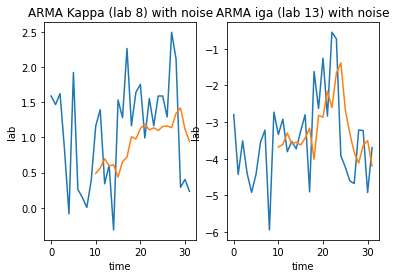

In [47]:
plt.subplot(1, 2, 1)
lab_id=8
tst_pred = pred_test_lst[0].Predicted_Values_ARMA[0:22]
plt.plot(np.arange(0,32), tst_labs[lab_id-1,0] )
plt.plot(np.arange(10,32), tst_pred)
plt.ylabel('lab')
plt.xlabel('time')
plt.title("ARMA Kappa (lab 8) with noise")
plt.figsize=(7, 15)

plt.subplot(1, 2, 2)
lab_id=13
tst_pred = pred_test_lst[1].Predicted_Values_ARMA[0:22]
plt.plot(np.arange(0,32), tst_labs[lab_id-1,0])
plt.plot(np.arange(10,32), tst_pred)
plt.ylabel('lab')
plt.xlabel('time')
plt.title("ARMA iga (lab 13) with noise")
plt.figsize=(7, 15)

### lab 13 iga

Text(0.5, 1.0, 'ARMA iga (lab 13) with noise')

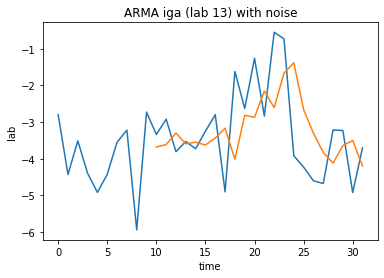

In [38]:
lab_id=13
tst_pred = pred_test_lst[1].Predicted_Values_ARMA[0:22]
plt.plot(np.arange(0,32), tst_labs[lab_id-1,0])
plt.plot(np.arange(10,32), tst_pred)
plt.ylabel('lab')
plt.xlabel('time')
plt.title("ARMA iga (lab 13) with noise")

#### lab 14 igg

Text(0.5, 1.0, 'ARMA igg (lab 14) with noise')

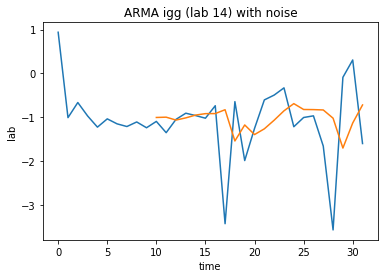

In [39]:
lab_id=14
tst_pred = pred_test_lst[2].Predicted_Values_ARMA[0:22]
plt.plot(np.arange(0,32), tst_labs[lab_id-1,0])
plt.plot(np.arange(10,32), tst_pred)
plt.ylabel('lab')
plt.xlabel('time')
plt.title("ARMA igg (lab 14) with noise")

#### lab 16 Lambda

Text(0.5, 1.0, 'ARMA Lambda (lab 16) with noise')

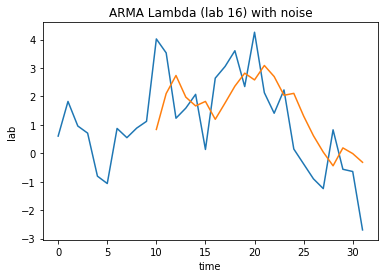

In [40]:
lab_id=16
tst_pred = pred_test_lst[3].Predicted_Values_ARMA[0:22]
plt.plot(np.arange(0,32), tst_labs[lab_id-1,0])
plt.plot(np.arange(10,32), tst_pred)
plt.ylabel('lab')
plt.xlabel('time')
plt.title("ARMA Lambda (lab 16) with noise")

### Residual Plot

In [17]:
# igg(14), iga(13), kappa(8), lambda(16)
def last_test_plot(lab_id):
  p = cv_pq[lab_id-1][0]
  q = cv_pq[lab_id-1][1]
      
  i=0
  lab1 = X_train[i]["lab_feat"][lab_id-1,:]     # lab defined here: in total 16 labs******************


  va_lab1 = X_test[i]["lab_feat"][lab_id-1,:]   # lab defined here: in total 16 labs******************


  y_val_lab = y_test[i]["lab_feat"][lab_id-1]   # lab defined here: in total 16 labs******************


  [df_train_arma, theta, intercept, train_RMSE_ARMA, res_tmp] = ARMA(lab1, p, q)
  [df_valid_arma, valid_RMSE_ARMA, valid_res_tmp] = pred_arma(p, q, va_lab1, theta, intercept)

  # pred one step further for arma on test set
  y_pred_val = pred_one_arma_baseline(p, q, va_lab1, valid_res_tmp, theta, intercept)
  y_pred_res = y_val_lab - np.array(y_pred_val).ravel()
  y_pred__val_rmse = np.sqrt(mean_squared_error(y_val_lab, y_pred_val))
    
  return y_pred_res



In [18]:
y_pred_res_lst = []
for i in [8, 13, 14, 16]:
    y_pred_res_lst.append(last_test_plot(i))

#### lab 8 kappa

Text(0.5, 1.0, 'ARMA Kappa (lab 8) with noise')

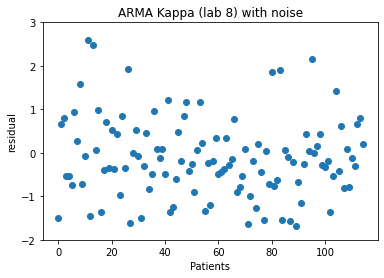

In [58]:
plt.scatter(np.arange(0,len(y_pred_res_lst[0])), y_pred_res_lst[0])
plt.ylabel('residual')
plt.xlabel('Patients')
plt.ylim(-2, 3)
plt.title("ARMA Kappa (lab 8) with noise")

#### lab 13 iga

Text(0.5, 1.0, 'ARMA iga (lab 13) with noise')

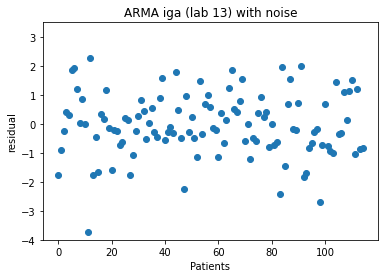

In [59]:
plt.scatter(np.arange(0,len(y_pred_res_lst[1])), y_pred_res_lst[1])
plt.ylabel('residual')
plt.xlabel('Patients')
plt.ylim(-4, 3.5)
plt.title("ARMA iga (lab 13) with noise")

#### lab 14 igg

Text(0.5, 1.0, 'ARMA igg (lab 14) with noise')

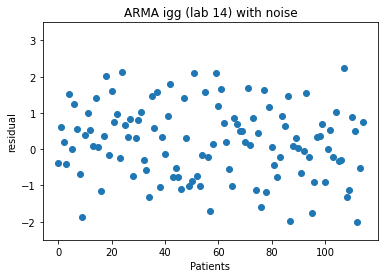

In [60]:
plt.scatter(np.arange(0,len(y_pred_res_lst[2])), y_pred_res_lst[2])
plt.ylabel('residual')
plt.xlabel('Patients')
plt.ylim(-2.5, 3.5)
plt.title("ARMA igg (lab 14) with noise")

#### lab 16 Lambda

Text(0.5, 1.0, 'ARMA Lambda (lab 16) with noise')

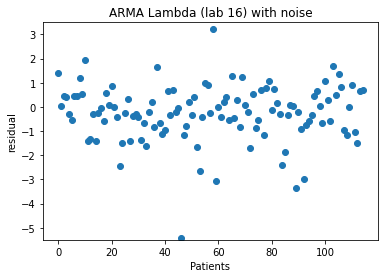

In [61]:
plt.scatter(np.arange(0,len(y_pred_res_lst[3])), y_pred_res_lst[3])
plt.ylabel('residual')
plt.xlabel('Patients')
plt.ylim(-5.5, 3.5)
plt.title("ARMA Lambda (lab 16) with noise")